## Produce blanc n(z) for ELGs

In [1]:
#- Basic imports
%pylab inline

import sys, os, glob
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import fitsio
from astropy.table import Table
#from desitarget.cmx.cmx_targetmask import cmx_mask
from desitarget.targets import desi_mask
from desitarget.sv1.sv1_targetmask import desi_mask, bgs_mask, mws_mask
from desiutil.dust import mwdust_transmission

Populating the interactive namespace from numpy and matplotlib


In [2]:
#global variables
fs = 20 #fontsize

Locating files

In [3]:
specprod = 'blanc'
specprod_dir = f'/global/cfs/cdirs/desi/spectro/redux/{specprod}'
sv1all = fitsio.read(specprod_dir + '/zcatalog-blanc-sv1all.fits')

condition for selecting ELGs; select galaxies with ZWARN ==0 and the appropriate ELG bit

In [4]:
sv1all['OBSCONDITIONS']

array([ 5,  5,  1, ..., 63, 63, 63], dtype=int32)

In [5]:
#list of tiles from https://data.desi.lbl.gov/desi/users/raichoor/fiberassign-sv1/sv1-per-tile/
pure_elg_tiles = np.array([80606, 80608, 80610, 80621, 80623])
qso_elg_tiles = np.arange(80667, 80711, 2)

In [14]:
targetids, ii = np.unique(sv1all['TARGETID'], return_index=True)
if len(targetids) < len(sv1all):
    sv1all = sv1all[ii]
    
targetcol = 'SV1_DESI_TARGET'
elgMask = desi_mask.mask('ELG_FDR_GFIB')

DELTACHI2_threshold = 50

desi_target = sv1all[targetcol]
isGal = (sv1all['SPECTYPE'] == 'GALAXY')
isRedshift = (sv1all['ZWARN'] == 0)
isDeltaChi2 = (sv1all['DELTACHI2'] >= DELTACHI2_threshold) #to select objects with SNR >= 5
isELGonlyTile = (sv1all['TILEID'] == 80606) | (sv1all['TILEID'] == 80608) | (sv1all['TILEID'] == 80610) | (sv1all['TILEID'] == 80621) | (sv1all['TILEID'] == 80623) #select ELG target tiles only

#apply flags
istotalELG = isGal & ((desi_target & elgMask) != 0) & isELGonlyTile
isGoodRedzELG = istotalELG & isRedshift
isGoodZChi2ELG = isGoodRedzELG & isDeltaChi2
isNoRedzELG = istotalELG & (~isRedshift)
#isGoodRedzELG = isGal & isRedshift & ((desi_target & elgMask) != 0) & isELGonlyTile
#isNoRedzELG = isGal & (~isRedshift) & ((desi_target & elgMask) != 0) & isELGonlyTile

Which `TILEID` are contributing to the n(z) mesurement

In [15]:
np.unique(sv1all[isGoodRedzELG]['TILEID'])

array([80606, 80608, 80610, 80621, 80623], dtype=int32)

## Q1: What fraction of ELGs did not get a redshift measurement (ZWARN != 0) ?

In [16]:
f_bad = np.sum(isNoRedzELG)/np.sum(istotalELG)
f_good = np.sum(isGoodRedzELG)/np.sum(istotalELG)
f_good_chi2 = np.sum(isGoodZChi2ELG)/np.sum(istotalELG)

In [17]:
print(f'fraction of ELGs without redshift: {np.round(f_bad, 3)}')
print(f'fraction of ELGs with redshift: {np.round(f_good, 3)}')
print(f'fraction of ELGs with redshift and DeltaChi2 >= 25: {np.round(f_good_chi2, 3)}')

fraction of ELGs without redshift: 0.061
fraction of ELGs with redshift: 0.939
fraction of ELGs with redshift and DeltaChi2 >= 25: 0.871


## Q2: Where do ELGs with (ZWARN != 0) reside in the $(g - r)$ vs. $(r - z)$ space?

Calculate the Milky Way dust transmission for all the ELGs

In [18]:
mw_transmission_g = np.zeros(len(sv1all))
mw_transmission_r = np.zeros(len(sv1all))
mw_transmission_z = np.zeros(len(sv1all))

for i in range(len(sv1all)):
    if(sv1all['PHOTSYS'][i] == ''): #these are OBJTYPE == BAD or SKY. Only 549 are TGT in the M33 + Dark tile as Anand mentioned
        mw_transmission_g[i] = mwdust_transmission(sv1all['EBV'][i], 'G', 'N')
        mw_transmission_r[i] = mwdust_transmission(sv1all['EBV'][i], 'R', 'N')
        mw_transmission_z[i] = mwdust_transmission(sv1all['EBV'][i], 'Z', 'N')
    else:
        mw_transmission_g[i] = mwdust_transmission(sv1all['EBV'][i], 'G', sv1all['PHOTSYS'][i])
        mw_transmission_r[i] = mwdust_transmission(sv1all['EBV'][i], 'R', sv1all['PHOTSYS'][i])
        mw_transmission_z[i] = mwdust_transmission(sv1all['EBV'][i], 'Z', sv1all['PHOTSYS'][i])

In [19]:
#from https://desi.lbl.gov/trac/wiki/TargetSelectionWG/SurveyValidation 
#NOT CORRECTED FOR MW_TRANSMISSION beause not provided in the blanc file
gr = -2.5*np.log10((sv1all['FLUX_G']/mw_transmission_g)/(sv1all['FLUX_R']/mw_transmission_r))
rz = -2.5*np.log10((sv1all['FLUX_R']/mw_transmission_r)/(sv1all['FLUX_Z']/mw_transmission_z)) 

<ipython-input-19-8a606950bcc5>:3: RuntimeWarning: divide by zero encountered in true_divide
  gr = -2.5*np.log10((sv1all['FLUX_G']/mw_transmission_g)/(sv1all['FLUX_R']/mw_transmission_r))
<ipython-input-19-8a606950bcc5>:3: RuntimeWarning: invalid value encountered in true_divide
  gr = -2.5*np.log10((sv1all['FLUX_G']/mw_transmission_g)/(sv1all['FLUX_R']/mw_transmission_r))
<ipython-input-19-8a606950bcc5>:3: RuntimeWarning: divide by zero encountered in log10
  gr = -2.5*np.log10((sv1all['FLUX_G']/mw_transmission_g)/(sv1all['FLUX_R']/mw_transmission_r))
<ipython-input-19-8a606950bcc5>:3: RuntimeWarning: invalid value encountered in log10
  gr = -2.5*np.log10((sv1all['FLUX_G']/mw_transmission_g)/(sv1all['FLUX_R']/mw_transmission_r))
<ipython-input-19-8a606950bcc5>:4: RuntimeWarning: divide by zero encountered in true_divide
  rz = -2.5*np.log10((sv1all['FLUX_R']/mw_transmission_r)/(sv1all['FLUX_Z']/mw_transmission_z))
<ipython-input-19-8a606950bcc5>:4: RuntimeWarning: invalid value enco

In [20]:
#DEFINE FDR CUT FOR PLOTTING PURPOSES ACCORDING TO https://desi.lbl.gov/trac/wiki/TargetSelectionWG/SurveyValidation 

def fdr_plot():
    #rz 0.3 cut 
    rz3_x = .3 * np.ones(10)
    rz3_y = np.linspace(-.5, .2, 10)
    
    #rz 1.6 cut
    rz16_x = 1.6 * np.ones(100)
    rz16_y = np.linspace(-.5, -.32, 100)
    
    #star/lowz cut
    lowz_x = np.arange(0.3, .75 + .01, .01)
    lowzSouth_y = 1.15 * lowz_x -.15
    lowzNorth_y = 1.15 * lowz_x -.20
    
    # [O II] cut
    OIIx = np.arange(.75, 1.6, .01)
    OIIy = -1.2 * OIIx + 1.6
    
    plt.plot(rz3_x, rz3_y, c = 'k')
    plt.plot(rz16_x, rz16_y, c = 'k')
    plt.plot(OIIx, OIIy, c = 'g', label = '[O II] cut')
    plt.plot(lowz_x, lowzNorth_y, c = 'r', label = 'lowz North cut')
    plt.plot(lowz_x, lowzSouth_y, c = 'r', ls = "--", label = 'lowz South cut')
    plt.legend(loc = 'best')

(-0.5, 1.0)

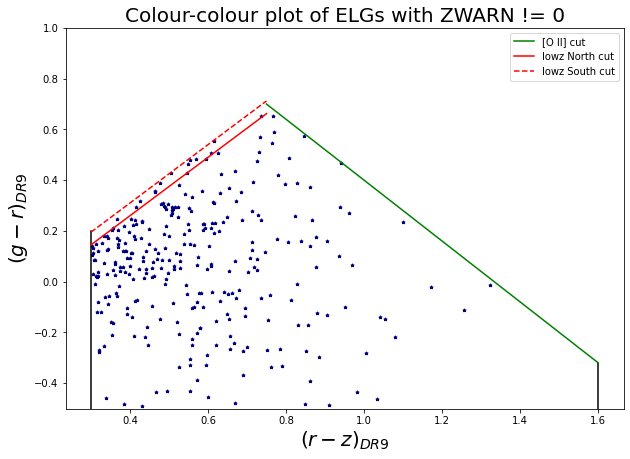

In [21]:
plt.figure(figsize=(10, 7))
fdr_plot()
plt.scatter(rz[isNoRedzELG], gr[isNoRedzELG], marker = "*", s = 10, c = 'navy')
plt.ylabel(r"$(g - r)_{DR9}$", fontsize = fs)
plt.xlabel(r"$(r - z)_{DR9}$", fontsize = fs)
plt.title("Colour-colour plot of ELGs with ZWARN != 0", fontsize = fs)
plt.ylim([-.5, 1])

## Q3: Where do the low redshift ELGs (ZWARN == 0 & Z < 0.6) reside in the $(g - r)$ vs. $(r - z)$ space?

In [22]:
# select lowz ELGs
islowzELG = isGoodRedzELG & (sv1all['Z'] < 0.6)

(-0.5, 1.0)

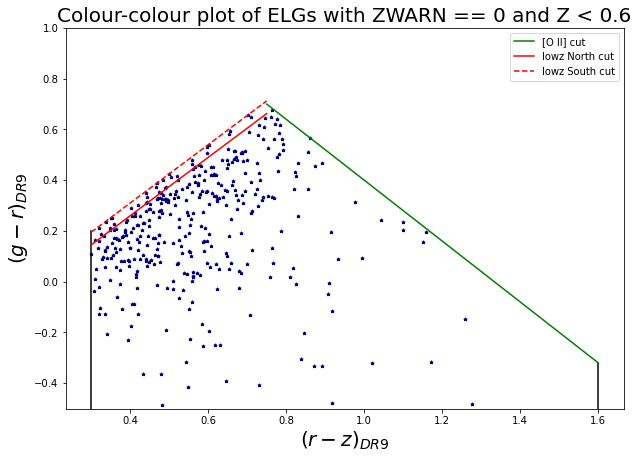

In [23]:
plt.figure(figsize=(10, 7))
fdr_plot()
plt.scatter(rz[islowzELG], gr[islowzELG], marker = "*", s = 10, c = 'navy')
plt.ylabel(r"$(g - r)_{DR9}$", fontsize = fs)
plt.xlabel(r"$(r - z)_{DR9}$", fontsize = fs)
plt.legend(loc = 'best')
plt.title("Colour-colour plot of ELGs with ZWARN == 0 and Z < 0.6", fontsize = fs)
plt.ylim([-.5, 1])

## Q4: Where are low SNR ELGs ($\Delta \chi^2$) with ZWARN == 0 reside in the $(g - r)$ vs. $(r - z)$ space?

In [25]:
islowSNR = isGoodRedzELG & (~isGoodZChi2ELG)
print(f"frac of objects with Delta Chi2 < 100: {np.sum(islowSNR)/np.sum(istotalELG)}")

frac of objects with Delta Chi2 < 100: 0.06854838709677419


(-0.5, 1.0)

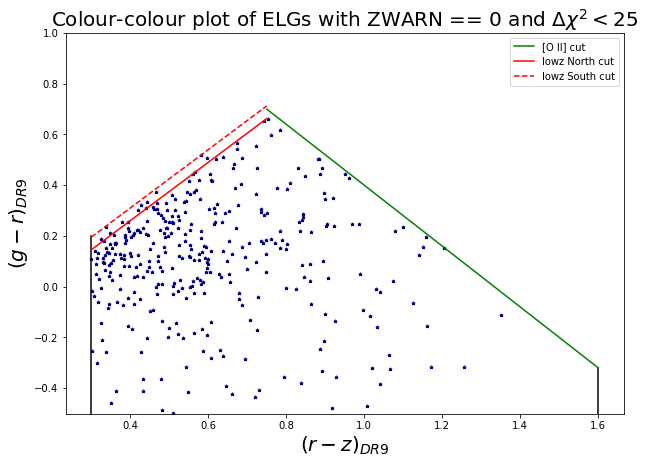

In [26]:
plt.figure(figsize=(10, 7))
fdr_plot()
plt.scatter(rz[islowSNR], gr[islowSNR], marker = "*", s = 10, c = 'navy')
plt.ylabel(r"$(g - r)_{DR9}$", fontsize = fs)
plt.xlabel(r"$(r - z)_{DR9}$", fontsize = fs)
plt.legend(loc = 'best')
plt.title(r"Colour-colour plot of ELGs with ZWARN == 0 and $\Delta \chi^2 < 25$", fontsize = fs)
plt.ylim([-.5, 1])

## Addendum: Where do all the good ELGs (ZWARN == 0 & Z >= 0.6) reside in the $(g - r)$ vs. $(r - z)$ space?

In [27]:
# select lowz ELGs
#isgoodELG = isGoodRedzELG & (sv1all['Z'] >= 0.6)
isgoodELG = isGoodZChi2ELG & (sv1all['Z'] >= 0.6)

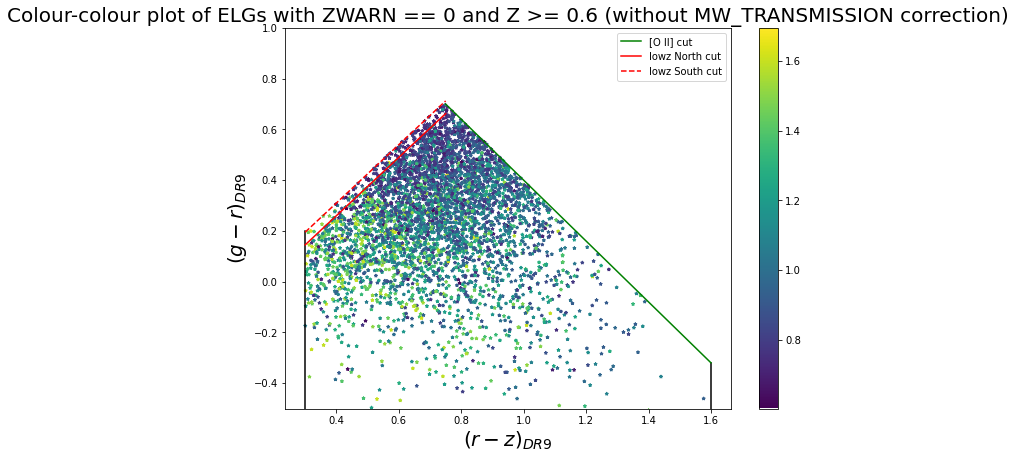

In [28]:
plt.figure(figsize=(10, 7))
fdr_plot()
plt.scatter(rz[isgoodELG], gr[isgoodELG], c = sv1all[isgoodELG]['Z'], marker = "*", s = 10)
plt.ylabel(r"$(g - r)_{DR9}$", fontsize = fs)
plt.xlabel(r"$(r - z)_{DR9}$", fontsize = fs)
plt.legend(loc = 'best')
plt.title("Colour-colour plot of ELGs with ZWARN == 0 and Z >= 0.6 (without MW_TRANSMISSION correction)", fontsize = fs)
plt.ylim([-.5, 1])
#plt.ylim([-.2, .4])
#plt.xlim([.2, .8])
plt.colorbar()

## Q4: What is the n(z) of the $5$ pure ELG tiles (ZWARN == 0 & $\Delta \chi^2 >= 25$)?

Number of ELGs with good redshifts: 4750


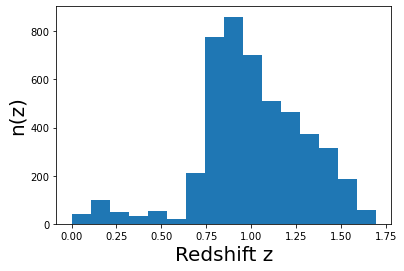

In [29]:
bins = 16
#zelg = sv1all[isGoodRedzELG]['Z']
zelg = sv1all[isGoodZChi2ELG]['Z']
print(f'Number of ELGs with good redshifts: {zelg.shape[0]}')

plt.xlabel("Redshift z", fontsize = fs)
plt.ylabel("n(z)", fontsize = fs)
plt.hist(zelg, bins = bins);

## Q5: Are there any spurious objects? 

Check for redshifts less than $0$ since `zelg.min()` < 0

In [30]:
zelg[zelg < 0]

array([-0.00050072])

In [31]:
sv1all[isGoodZChi2ELG][zelg < 0]['TARGETID']

array([39632940363154450])

**Note:** There is at least one with ZWARN == 0 but Z < 0. Upong inspecting the object's spectra, it has $\Delta \chi^2 > 140$ and but the spectra does not have any [O II] signature.  Something to think about is how often objects like these are passed as good by the pipeline and how to better remove them from n(z) analysis? 

## Q5: What is the p(z) of these $5$ tiles?

### Convert n(z) to p(z) while taking into account that $\int p(z) dz = f_{good}$ because we must account for ELGs that do not have a redshift measurement. 

Text(0, 0.5, 'p(z)')

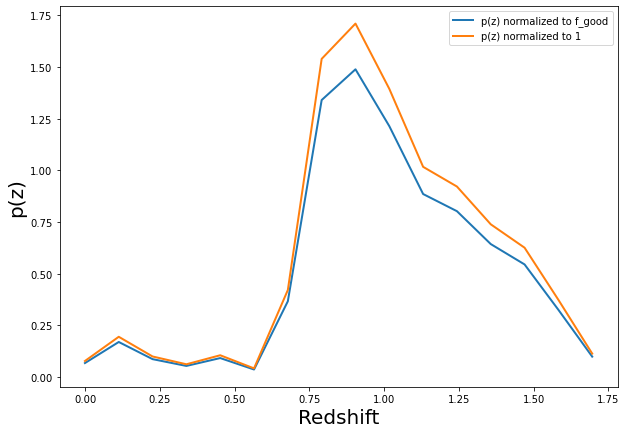

In [32]:
#crude estimation using numpy
pz_full, bin_ledge = np.histogram(zelg, bins=bins, density=True) #usual pz normalized to 1
weights_fgood = np.ones(len(zelg)) * 1/(np.diff(bin_ledge)[0] * len(zelg)) * f_good_chi2 #weights to normalize to f_good
pz_good, _ = np.histogram(zelg, bins=bins, weights = weights_fgood) #convert n(z) to p(z) normalized to f_good 
centr_z = np.linspace(bin_ledge[0], bin_ledge[0] + np.ediff1d(bin_ledge)[0] * (len(bin_ledge) - 1), len(bin_ledge) - 1) #find the central values of the histograms for plotting purposes

plt.figure(figsize=(10,7))
plt.plot(centr_z, pz_good, label = 'p(z) normalized to f_good', lw = 2)
plt.plot(centr_z, pz_full, label = 'p(z) normalized to 1', lw = 2)
#plt.hist(zelg, bins = 100, histtype= 'step', alpha = 0.6, color = 'darkgreen', lw = 1.5, density = True);
plt.legend(loc = 'best')
plt.xlabel("Redshift", fontsize = fs)
plt.ylabel("p(z)", fontsize = fs)

### Check integration of the histograms to make sure they are normalized properly

In [33]:
print(f'Integral under the normalized to 1 curve: {sp.integrate.trapz(pz_full, centr_z, dx = np.ediff1d(centr_z)[0])}')
print(f'Integral under the normalized to f_good curve: {sp.integrate.trapz(pz_good, centr_z, dx = np.ediff1d(centr_z)[0])}')

Integral under the normalized to 1 curve: 1.0558877192982457
Integral under the normalized to f_good curve: 0.919257086999032


### Estimate PDF of the histogram normalized to f_good using Gaussian KDE

Text(1.2, 1.2, '# of ELGs = 4750')

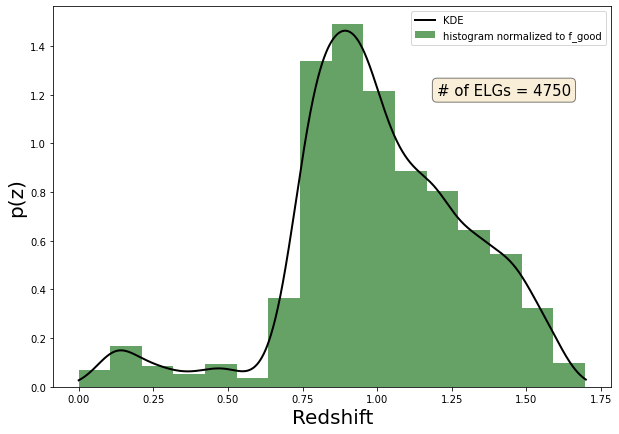

In [34]:
#use scipy to estimate the PDF using a Gaussian KDE
from scipy.stats import gaussian_kde

kernel = gaussian_kde(zelg)
zrange = np.arange(0., 1.7, .001)

plt.figure(figsize=(10,7))
#plt.plot(centr_z, pz_good, label = 'p(z) normalized to f_good', lw = 2)
#plt.plot(centr_z, pz_full, label = 'p(z) normalized to 1', lw = 2)
plt.plot(zrange, kernel(zrange)*f_good_chi2, c = 'black', lw = 2, label = 'KDE') #multiply by f_good because we want the PDF to account for missing redshifts, so the integral must be equal to f_good
plt.hist(zelg, bins = 16, weights = weights_fgood, alpha = 0.6, color = 'darkgreen', lw = 1.5, label = 'histogram normalized to f_good');
plt.legend(loc = 'best')
plt.xlabel("Redshift", fontsize = fs)
plt.ylabel("p(z)", fontsize = fs)
# For adding text
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(x = 1.2, y = 1.2, s = f'# of ELGs = {zelg.shape[0]}', fontsize = 15, bbox = props)

Verify that the ingeral is equal to `f_good_chi2`. 

In [35]:
#check integral
sp.integrate.trapz(kernel(zrange) * f_good_chi2, zrange, dx = 0.001)

0.8687249207779661

## Q6: How does the measured n(z) compare to the DESI FDR forecast? 

In [36]:
#DESI forecast for comparison from FDR
redz_range = np.arange(0.65, 1.75, .1)
dndzddeg2 = np.array([309, 2269, 1923, 2094, 1441, 1353, 1337, 523, 466, 329, 126])

In [37]:
bins = 17
pz_full, bin_ledge = np.histogram(zelg, bins=bins, density=True, range = (0., 1.7))

Text(1.2, 1600, '# of ELGs = 4750')

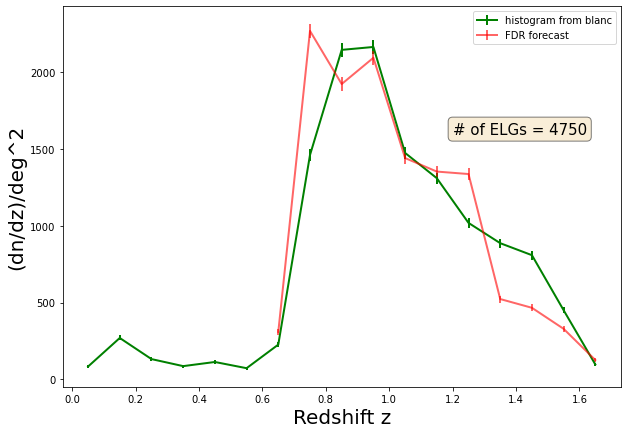

In [38]:
num_density = 1280 #per deg2 for normalizing

plt.figure(figsize=(10, 7))

plt.errorbar(bin_ledge[:-1] + .05, num_density * pz_full, yerr = np.sqrt(num_density * pz_full), label = 'histogram from blanc', c = 'g', lw = 2) #Poisson error bar
plt.errorbar(redz_range, dndzddeg2, yerr = np.sqrt(dndzddeg2), c = 'r', label = 'FDR forecast', lw = 2, alpha = 0.6)
plt.xlabel("Redshift z", fontsize = fs)
plt.ylabel("(dn/dz)/deg^2", fontsize = fs)
plt.legend(loc = 'best')

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(x = 1.2, y = 1600, s = f'# of ELGs = {zelg.shape[0]}', fontsize = 15, bbox = props)

## Q7: Given the measured n(z) is correct, what is the expected number density for the AbacusSummit ELG mock catalogues?

In [104]:
#check the abacus bin widths
abacus_centr = np.array([0.450,  0.500,  0.576,  0.651,  0.726,  0.800,  0.878,  0.950,  1.026,  1.100,  1.179,  1.251,  1.327,  1.400,  1.476,  2.256])
np.diff(abacus_centr)

array([0.05 , 0.076, 0.075, 0.075, 0.074, 0.078, 0.072, 0.076, 0.074,
       0.079, 0.072, 0.076, 0.073, 0.076, 0.78 ])

In [105]:
#generate array of left edges of the bins with width 0.075 except the first bins
first_bins = np.array([0, 0.4375])
equal_width_bins = np.arange(0.4625, 1.8, .075)

abacus_bins = np.concatenate([first_bins, equal_width_bins])
abacus_bins

array([0.    , 0.4375, 0.4625, 0.5375, 0.6125, 0.6875, 0.7625, 0.8375,
       0.9125, 0.9875, 1.0625, 1.1375, 1.2125, 1.2875, 1.3625, 1.4375,
       1.5125, 1.5875, 1.6625, 1.7375])

In [106]:
# calculate p(z) assuming integral to 1
pz_full, bin_ledge = np.histogram(zelg, bins=abacus_bins, density=True, range = (0., 1.7))

In [107]:
# calculate bin centres and bin widths
bin_widths = np.diff(bin_ledge)
bin_mid = abacus_bins[:-1] + bin_widths/2

In [108]:
df = pd.DataFrame({'Redshift_Ledge' : bin_ledge[:-1], 'Redshift_mid' : bin_mid, 'Bin_width' : bin_widths, 'dndz/deg^2' : num_density * pz_full})
df.to_csv("nz_blanc.txt")

In [109]:
df

,Redshift_Ledge,Redshift_mid,Bin_width,dndz/deg^2
0,0.0000,0.21875,0.4375,136.151370
1,0.4375,0.45000,0.0250,150.937039
2,0.4625,0.50000,0.0750,125.780866
3,0.5375,0.57500,0.0750,53.906085
4,0.6125,0.65000,0.0750,190.468169
5,0.6875,0.72500,0.0750,1067.340493
6,0.7625,0.80000,0.0750,2023.275075
7,0.8375,0.87500,0.0750,2177.805854
8,0.9125,0.95000,0.0750,2192.180810
9,0.9875,1.02500,0.0750,1588.432652


Text(0.5, 1.0, 'Expected number density for ELG mock catalogues from AbacusSummit')

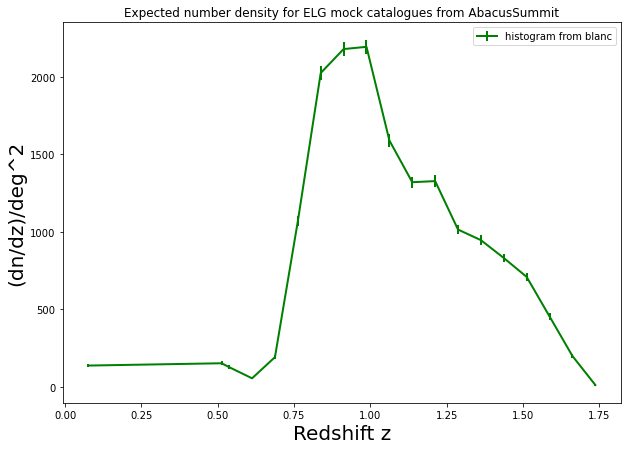

In [110]:
plt.figure(figsize=(10, 7))

plt.errorbar(bin_ledge[:-1] + .15/2, num_density * pz_full, yerr = np.sqrt(num_density * pz_full), label = 'histogram from blanc', c = 'g', lw = 2) #Poisson error bar
plt.xlabel("Redshift z", fontsize = fs)
plt.ylabel("(dn/dz)/deg^2", fontsize = fs)
plt.legend(loc = 'best')
plt.title("Expected number density for ELG mock catalogues from AbacusSummit")

## Q8: How does the measured n(z) compare with Ashley Ross's n(z)? 

In [46]:
fdr_gfib_nz_aross = pd.read_csv('/global/cfs/cdirs/desi/survey/catalogs/SV1/LSS/LSScats/v0/ELG_FDR_GFIBalltiles_deep_nz.dat', delimiter=" ", header=1)
fdr_gfib_nz_aross

,#zmid,zlow,zhigh,n(z),Nbin,Vol_bin
0,0.015,0.01,0.02,0.028623,1,152.152310
1,0.025,0.02,0.03,0.000000,0,409.373418
2,0.035,0.03,0.04,0.011025,2,790.007150
3,0.045,0.04,0.05,0.006749,2,1290.501416
4,0.055,0.05,0.06,0.004567,2,1907.317624
...,...,...,...,...,...,...
154,1.555,1.55,1.56,0.000333,23,300975.291195
155,1.565,1.56,1.57,0.000216,15,301835.474529
156,1.575,1.57,1.58,0.000273,19,302679.995669
157,1.585,1.58,1.59,0.000187,13,303509.474867


In [62]:
#check for number of ELGs from Ashley's table
total_ashley = np.sum(fdr_gfib_nz_aross['Nbin'])
print(f'Number of good ELGs in Ashley\'s table: {total_ashley}')

Number of good ELGs in Ashley's table: 4696


In [56]:
#check for number of ELGs from my table in the same redshift bin ranges
bins = 170
nz_full, bin_ledge = np.histogram(zelg, bins = bins, range = (0., 1.7))

print(f'Number of good ELGs in the same redshift range: {np.sum(nz_full[1:][bin_ledge[1:-1] <= 1.59])}')

Number of good ELGs in the same redshift range: 4847


There is a discrepancy between number of **good** objects between the two samples. 

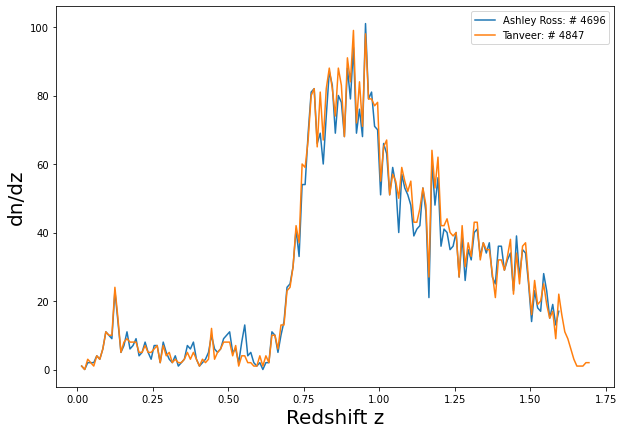

In [75]:
plt.figure(figsize=(10, 7))
plt.plot(fdr_gfib_nz_aross['#zmid'], fdr_gfib_nz_aross['Nbin'], label = f'Ashley Ross: # {total_ashley}')
plt.plot(bin_ledge[1:-1] + .01/2, nz_full[1:], label = f'Tanveer: # {np.sum(nz_full[1:][bin_ledge[1:-1] <= 1.59])}')
plt.xlabel("Redshift z", fontsize = fs)
plt.ylabel("dn/dz", fontsize = fs)
plt.legend(loc = 'best')

Text(0.5, 1.0, 'Comparison of n(z)')

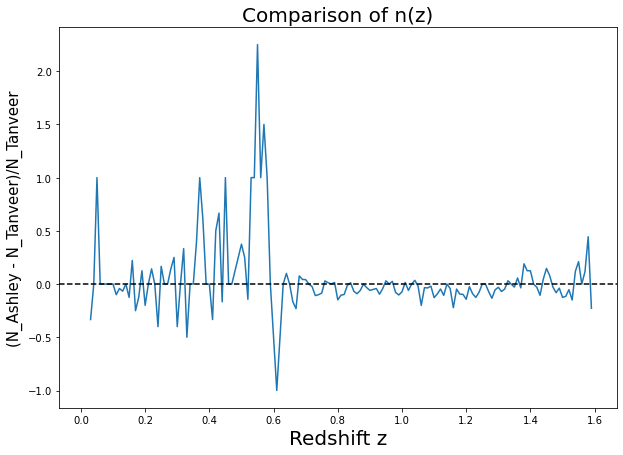

In [71]:
plt.figure(figsize=(10, 7))

plt.plot(bin_ledge[1:-1][bin_ledge[1:-1] <= 1.59], (fdr_gfib_nz_aross['Nbin'] - nz_full[1:][bin_ledge[1:-1] <= 1.59])/nz_full[1:][bin_ledge[1:-1] <= 1.59])
plt.axhline(0, ls = "--", c = 'k')
plt.xlabel("Redshift z", fontsize = fs)
plt.ylabel("(N_Ashley - N_Tanveer)/N_Tanveer", fontsize = fs-5)
plt.title("Comparison of n(z)", fontsize = fs)

In [74]:
sv1all['LOCATION']

array([1483, 1464, 1463, ..., 7313, 6145, 8027])

In [7]:
tmp = fitsio.read("/global/cfs/cdirs/desi/survey/catalogs/SV1/redshift_comps/blanc/v0/ELG/alltiles_ELGzinfo.fits")

In [9]:
tmp.shape

(182043,)

In [11]:
targetids, ii = np.unique(tmp['TARGETID'], return_index=True)
if len(targetids) < len(tmp):
    tmp = tmp[ii]

In [12]:
tmp.shape

(26051,)

In [14]:
tmp[tmp['ZWARN'] == 0].shape

(15734,)

In [16]:
targetcol = 'SV1_DESI_TARGET'
elgMask = desi_mask.mask('ELG_FDR_GFIB')

desi_target = tmp[targetcol]
isGal = (tmp['SPECTYPE'] == 'GALAXY')
isRedshift = (tmp['ZWARN'] == 0)
isDeltaChi2_25 = (tmp['DELTACHI2'] >= 25) #to select objects with SNR >= 5
isELGonlyTile = (tmp['TILEID'] == 80606) | (tmp['TILEID'] == 80608) | (tmp['TILEID'] == 80610) | (tmp['TILEID'] == 80621) | (tmp['TILEID'] == 80623) #select ELG target tiles only

#apply flags
istotalELG = isGal & ((desi_target & elgMask) != 0) & isELGonlyTile
isGoodRedzELG = istotalELG & isRedshift
isGoodZChi2ELG = isGoodRedzELG & isDeltaChi2_25
isNoRedzELG = istotalELG & (~isRedshift)

In [18]:
tmp[isGoodZChi2ELG].shape

(4061,)

(array([ 28.,  88.,  43.,  31.,  51.,  25., 187., 694., 775., 589., 424.,
        380., 310., 250., 143.,  43.]),
 array([-8.62341029e-04,  1.05164034e-01,  2.11190410e-01,  3.17216785e-01,
         4.23243160e-01,  5.29269535e-01,  6.35295911e-01,  7.41322286e-01,
         8.47348661e-01,  9.53375037e-01,  1.05940141e+00,  1.16542779e+00,
         1.27145416e+00,  1.37748054e+00,  1.48350691e+00,  1.58953329e+00,
         1.69555966e+00]),
 <a list of 16 Patch objects>)

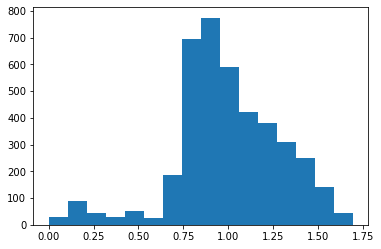

In [21]:
plt.hist(tmp[isGoodZChi2ELG]['Z'], bins = 16)

## TODO: What fraction of ELGs are also labelled as QSOs in each of the $5$ tiles?

In [34]:
def elg_classified_qso(tileid, data = sv1all, verbose = False):
    """Returns fraction of ELGs also labelled as QSOs for a given tile"""
    
    targetcol = 'SV1_DESI_TARGET'
    elgMask = desi_mask.mask('ELG_FDR_GFIB')
    qsoMask = desi_mask.mask('QSO')
    desi_target = sv1all[targetcol]
    
    #appropriate flags
    isGal = (sv1all['SPECTYPE'] == 'GALAXY')
    isRedshift = (sv1all['ZWARN'] == 0)
    istile = data['TILEID'] == tileid 
    
    #apply flags
    #first calculate numbers of ELG
    isELG = isGal & ((desi_target & elgMask) != 0) & istile
    isGoodRedzELG = isELG & isRedshift
    isNoRedzELG = isELG & (~isRedshift)
    
    isELGandQSO = isELG & ((desi_target & qsoMask) != 0)
    isGoodRedzELGandQSO = isELGandQSO & isRedshift
    isNoRedzELGandQSO = isELGandQSO & (~isRedshift)
    
    #calculate statistics
    frac_QSOELG = np.sum(isELGandQSO)/np.sum(isELG)
    frac_Good_QSOELG = np.sum(isGoodRedzELGandQSO)/np.sum(isGoodRedzELG)
    frac_NoZ_QSOELG = np.sum(isNoRedzELGandQSO)/np.sum(isNoRedzELG)
    
    if(verbose == True):
        print(f"fraction of ESOs also QSOs: {frac_QSOELG}")
        print(f"fraction of good redshift ESOs also QSOs: {frac_Good_QSOELG}")
        print(f"fraction of bad/no redshift ESOs also QSOs: {frac_NoZ_QSOELG}")
    
    return frac_QSOELG, frac_Good_QSOELG, frac_NoZ_QSOELG

In [35]:
frac_QSOELG = np.zeros(len(pure_elg_tiles))
frac_Good_QSOELG = np.zeros(len(pure_elg_tiles))
frac_NoZ_QSOELG = np.zeros(len(pure_elg_tiles))

for i in range(len(pure_elg_tiles)):
    frac_QSOELG[i], frac_Good_QSOELG[i], frac_NoZ_QSOELG[i] = elg_classified_qso(pure_elg_tiles[i])

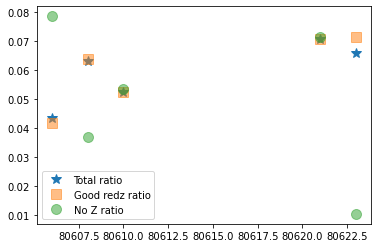

In [49]:
plt.plot(pure_elg_tiles, frac_QSOELG, ls = "", marker = "*", markersize = 10, label = "Total ratio")
plt.plot(pure_elg_tiles,frac_Good_QSOELG, ls = "", marker = "s", markersize = 10, alpha = 0.5, label = "Good redz ratio")
plt.plot(pure_elg_tiles,frac_NoZ_QSOELG, ls = "", marker = "o", markersize = 10, alpha = 0.5, label = "No Z ratio")
plt.legend(loc = 'best')

In [50]:
np.mean(frac_QSOELG)

0.059010919931061466

In [51]:
np.std(frac_QSOELG)

0.009825630588326875